# Autoregressive moving average

## Install packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 215kB 306kB/s ta 0:00:01
  Found existing installation: seaborn 0.7.1
    DEPRECATION: Uninstalling a distutils installed project (seaborn) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.arima_model import ARMA
import matplotlib.pyplot as plt
import seaborn as sns
import quiz_tests

In [3]:
sns.set()
#note that for the figure size to show, this cell should be run
#separately from the import of pyplot
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## Simulate return series with autoregressive properties

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(200)

ar_params = np.array([1, -0.5])
ma_params = np.array([1, -0.3])
ret = ArmaProcess(ar_params, ma_params).generate_sample(nsample=5*252)

ret = pd.Series(ret)
drift = 100
price = pd.Series(np.cumsum(ret)) + drift

In [6]:
print (ret)

0      -1.45094825
1       1.62076348
2       0.94897496
3       0.01318544
4       0.44238044
5       0.07980068
6      -0.17156148
7       0.45788005
8      -0.60617638
9       0.69649955
10      0.18389713
11      1.37325986
12      0.50912561
13      1.20786731
14      2.21044075
15      0.00203521
16      2.00205425
17     -0.60884850
18     -0.85017001
19      0.07142138
20     -1.18976053
21      0.96635831
22     -1.17507514
23      0.62331296
24     -0.26731149
25     -1.31543942
26     -0.05475319
27      1.99053629
28      0.12200781
29      0.40292972
           ...    
1230   -1.51471635
1231   -0.71949620
1232    0.54420715
1233    0.97357388
1234    0.33373419
1235   -2.41259936
1236    0.04371228
1237   -0.81463724
1238   -0.28477172
1239    0.92514568
1240   -0.15322245
1241    0.30990013
1242   -0.89550560
1243   -0.24221825
1244    1.39863435
1245    2.44987705
1246    0.46805493
1247    2.11105819
1248   -0.79404990
1249    1.47961000
1250   -0.31257396
1251    1.10

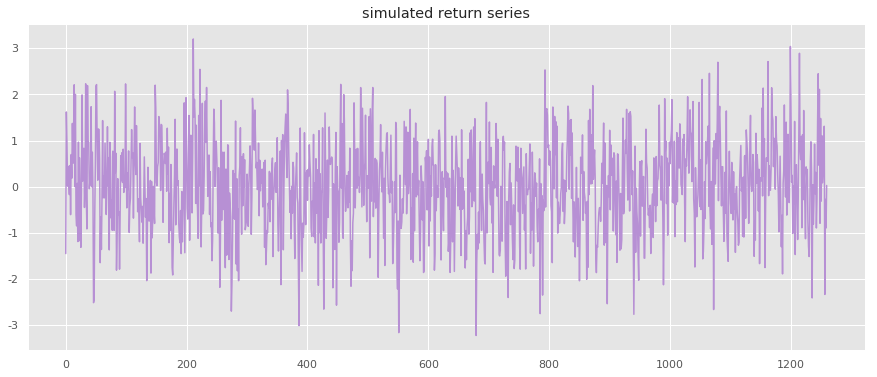

In [5]:
ret.plot(figsize=(15,6), color=sns.xkcd_rgb["pale purple"], title="simulated return series")
plt.show()

In [7]:
print(price)

0       98.54905175
1      100.16981523
2      101.11879019
3      101.13197563
4      101.57435608
5      101.65415676
6      101.48259528
7      101.94047534
8      101.33429896
9      102.03079851
10     102.21469564
11     103.58795550
12     104.09708111
13     105.30494842
14     107.51538917
15     107.51742438
16     109.51947863
17     108.91063013
18     108.06046011
19     108.13188149
20     106.94212096
21     107.90847926
22     106.73340412
23     107.35671708
24     107.08940560
25     105.77396618
26     105.71921299
27     107.70974928
28     107.83175709
29     108.23468681
           ...     
1230   111.26631416
1231   110.54681796
1232   111.09102511
1233   112.06459899
1234   112.39833319
1235   109.98573382
1236   110.02944611
1237   109.21480887
1238   108.93003715
1239   109.85518283
1240   109.70196038
1241   110.01186051
1242   109.11635491
1243   108.87413667
1244   110.27277102
1245   112.72264807
1246   113.19070300
1247   115.30176119
1248   114.50771130


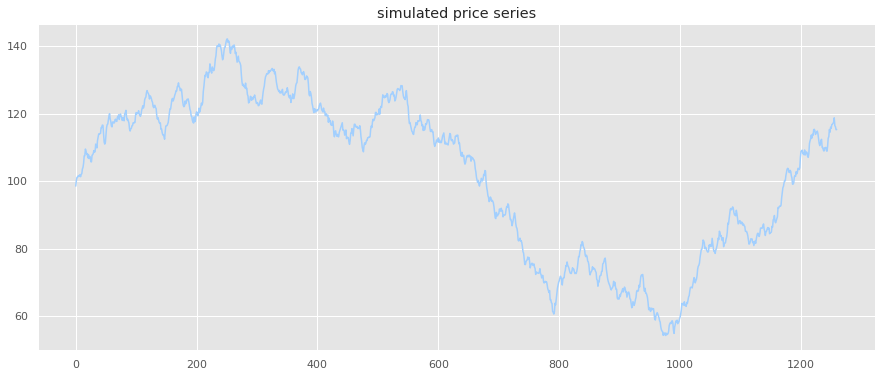

In [8]:
price.plot(figsize=(15,6), color=sns.xkcd_rgb["baby blue"], title="simulated price series")
plt.show()

### log returns

In [9]:
lret = np.log(price) - np.log(price.shift(1))
lret = lret[1:]

## autocorrelation

Use autocorrelation to get a sense of what lag to use for the autoregressive model.  

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

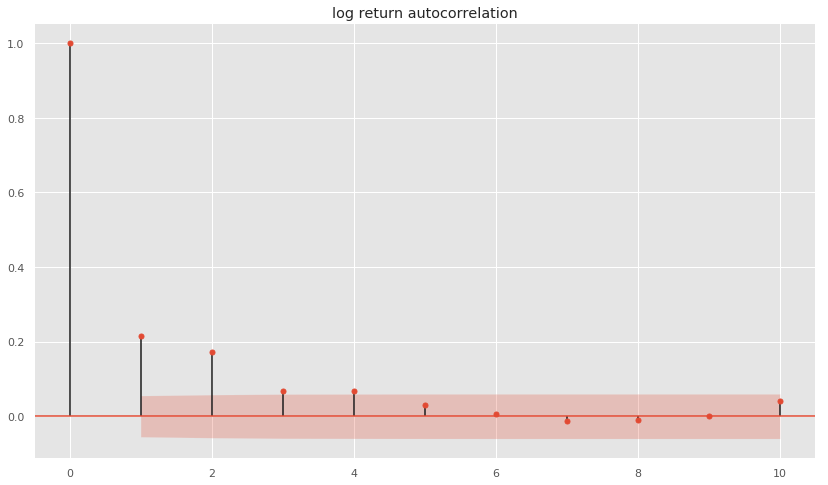

In [21]:
_ = plot_acf(lret,lags=10, title='log return autocorrelation')
plt.show()

Since the sample series was simulated to have autoregressive properties, we also see autocorrelation between the current periods and the lags.

Note that with actual stock data, there won't be much autocorrelation of returns from one day to the next.  
Stock returns (log returns and normal returns) can be described as a "random walk", in that each new period's value is more or less random.

## plot partial autocorrelation

In [12]:
from statsmodels.graphics.tsaplots import plot_pacf

Notice how the partial autocorrelation of price shows that most of the correlation is found in the previous period.  Partial autocorrelation is different from autocorrelation in that it shows the influence of each period that is not attributed to the other periods leading up to the current period.  In other words, the two-day lag had a fairly strong correlation with the current value because it had a strong correlation with the one-day lag. However, the two-day lag's partial correlation with the current period that isn't attributable to the one-day lag is relatively small.

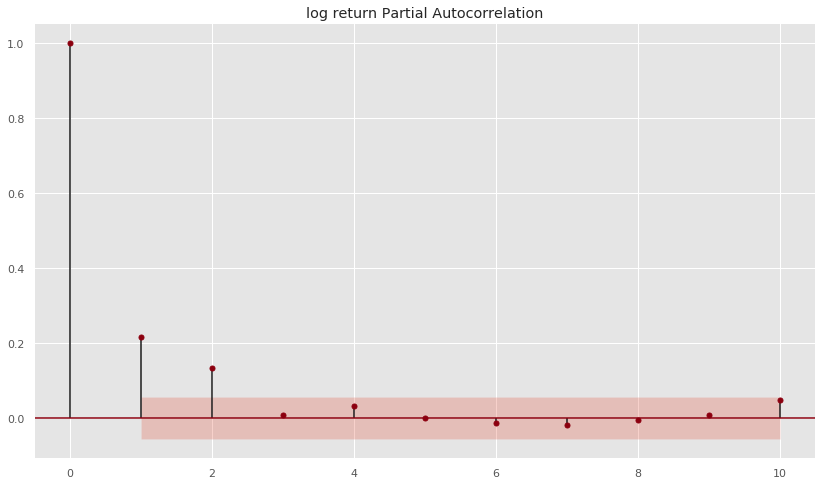

In [20]:
_ = plot_pacf(lret, lags=10, title='log return Partial Autocorrelation', color=sns.xkcd_rgb["crimson"])
plt.show()

## Discussion

Notice that there isn't much correlation between previous periods with the current period.  In general, using past stock returns to predict future stock returns is rather difficult.  Volatility tends to have more of a correlation with past volatility.  We'll cover volatility in a later lesson within this module.

## Ljung-Box Test

The Ljung-Box test helps us check whether the lag we chose gives autocorrelations that are significantly different from zero.  The null hypothesis is that the previous lags as a whole are not correlated with the current period.  If the p-value is small enough (say 0.05), we can reject the null and assume that the past lags have some correlation with the current period.

```

returns:
lbvalue (float or array) – test statistic
pvalue (float or array) – p-value based on chi-square distribution
... (we'll ignore the other outputs, which are for another similar hypothesis test)
```

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [23]:
lb_test_stat, lb_p_value = acorr_ljungbox(lret,lags=20)
lb_p_value

array([2.01640711e-14, 1.24123312e-21, 5.10501473e-22, 1.86446247e-22,
       6.13688232e-22, 2.96811370e-21, 1.18392407e-20, 4.64232373e-20,
       1.78935377e-19, 2.36770725e-19, 5.54712773e-19, 1.32980392e-18,
       3.72359442e-18, 5.86709112e-18, 1.72205886e-17, 4.22143078e-17,
       1.15704571e-16, 9.89290170e-17, 2.59299780e-16, 1.50593115e-16])

## Discussion

Since this series was simulated to have autoregressive properties, the Ljung-Box test shows p-values less than 0.05 for the 20 lag periods that we tested.

## Fit an ARMA model

For the purpose of familiarizing ourselves with the ARMA model, we'll fit the model to our simulated return series.

We'll just use one lag for the autoregression and one lag for the moving average.  
Check out the [statsmodel arma](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARMA.html) documentation.

In [24]:
from statsmodels.tsa.arima_model import ARMA

In [34]:
AR_lag_p = 1
MA_lag_q = 1
order = (AR_lag_p, MA_lag_q)
arma_model = ARMA(lret.values, order=order)
arma_result = arma_model.fit()
arma_pred = pd.Series(arma_result.fittedvalues)

## View fitted predictions against actual values

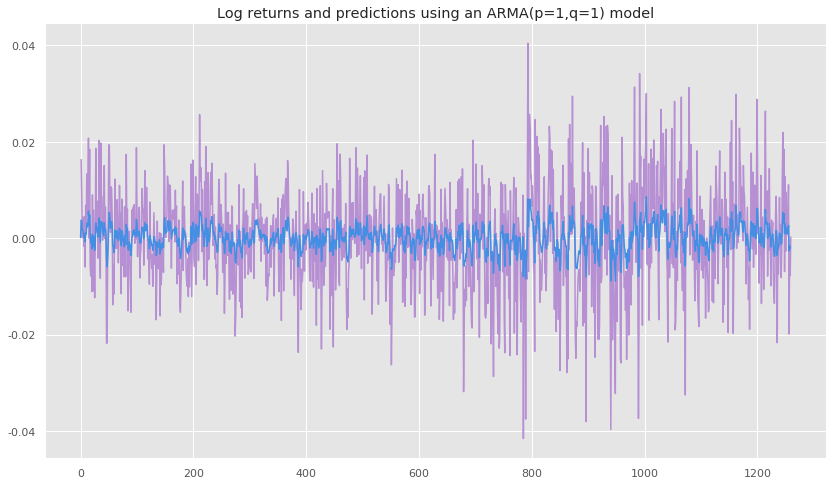

Fitted AR parameter 0.65, MA parameter -0.45


In [43]:
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arma_pred, color=sns.xkcd_rgb["dark sky blue"])
plt.title('Log returns and predictions using an ARMA(p=1,q=1) model');
plt.show()
print("Fitted AR parameter {0:.2f}, MA parameter {1:.2f}".format(arma_result.arparams[0],arma_result.maparams[0]))

## Discussion

In general, autoregressive moving average models are not able to forecast stock returns because stock returns are non-stationary and also quite noisy.

There are other techniques that build upon the concepts of ARMA models, so the goal here was really to help you get familiar with these concepts, as they are the basis for other models that you'll see later in this module.

## Quiz: ARIMA

Fit an autoregressive integrated moving average model.  Choose an order of integration of 1, autoregresion lag of 1, and moving average lag of 1.

Check out the [stats model arima](http://www.statsmodels.org/0.6.1/generated/statsmodels.tsa.arima_model.ARMAResults.html) documentation to help you.

In [45]:
from statsmodels.tsa.arima_model import ARIMA

In [49]:
def fit_arima(lret):
    
    #TODO: choose autoregression lag of 1
    AR_lag_p =1
    
    #TODO: choose moving average lag of 1
    MA_lag_q =1
    
    #TODO: choose order of integration 1
    order_of_integration_d =1
    
    #TODO: Create a tuple of p,d,q
    Order = (AR_lag_p,order_of_integration_d,MA_lag_q)
    
    #TODO: create an ARIMA model object, passing in the values of the lret pandas series,
    # and the tuple containing the (p,d,q) order arguments
    arima_model = ARIMA(lret, order=Order)  
    
    arima_result = arima_model.fit()
    
    #TODO: from the result of calling ARIMA.fit(),
    # save and return the fitted values, autoregression parameters, and moving average parameters
    fittedvalues = arima_result.fittedvalues
    arparams = arima_result.arparams
    maparams = arima_result.maparams
    return fittedvalues,arparams,maparams

quiz_tests.test_fit_arima(fit_arima)

Tests Passed


In [ ]:
fittedvalues,arparams,maparams = fit_arima(lret)
arima_pred = pd.Series(fittedvalues)
plt.plot(lret, color=sns.xkcd_rgb["pale purple"])
plt.plot(arima_pred, color=sns.xkcd_rgb["jade green"])
plt.title('Log Returns and predictions using an ARIMA(p=1,d=1,q=1) model');
print(f"fitted AR parameter {arparams[0]:.2f}, MA parameter {maparams[0]:.2f}")

If you're stuck, you can also check out the solution [here](autoregression_solution.ipynb)